# Harmony Feature Examples

This notebook provides condensed examples of using Harmony to perform specific tasks.  For more a general introduction and tutorial, see [Harmony API Introduction](./Harmony%20Api%20Introduction.ipynb).  Useful helpers for making the calls found in this note book can be found under the [docs/notebook-helpers](./notebook-helpers) folder

## Prerequisites

1. Install Python 3.  This notebook is tested to work in 3.8 but should work in most recent 3.x versions.
2. Install Jupyter: `pip install jupyterlab`
3. Setup your `~/.netrc` for Earthdata Login as described in [Harmony API Introduction](./Harmony%20Api%20Introduction.ipynb)
4. Run the following cell to install Python dependencies, import necessary modules, and set notebook defaults

In [6]:
%load_ext autoreload
%autoreload
%matplotlib inline

import sys
# Install dependencies into the Jupyter Kernel
!{sys.executable} -m pip install -q -r notebook_helpers/requirements.txt

# Import libraries used throughout the notebook
from notebook_helpers import get, post, show, get_data_urls, show_async, show_async_condensed, show_shape, print_async_status

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You should consider upgrading via the 'pip install --upgrade pip' command.


## Example Data

Harmony has produced example collections with artificial data but realistic structure to allow testing our services.  We have L3 and L2 NetCDF4 collections, and a shapefile collection.

In [2]:
l3_collection = 'C1234088182-EEDTEST'
l2_collection = 'C1233860183-EEDTEST'
shapefile_collection = 'C1234530533-EEDTEST'

In [ ]:
response = get('https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/harmony_example_v2/nc/2020_01_15_ff4c00_global.nc')
show(response)

## OGC API - Coverages Requests

In [3]:
coverages_root = 'https://harmony.uat.earthdata.nasa.gov/{collection}/ogc-api-coverages/1.0.0/collections/{variable}/coverage/rangeset'

### Bounding Box and Temporal Subsetting with Reformatting

In [ ]:
params = {
    'subset': [
        'lon(-20:90)', 
        'lat(0:60)', 
        'time("2020-01-15T00:00:00Z":"2020-01-15T01:00:00Z")']
}
response = get(
    coverages_root.format(
        collection=l3_collection, 
        variable='all'), 
    params=params)

show(response)

### Variable Subsetting

In [ ]:
response = get(
    coverages_root.format(
        collection=l3_collection, 
        variable='green_var'), 
    params=params)

show(response, color_index=1)

### Shapefile Subsetting

In [ ]:
show_shape('./notebook_helpers/namibia.geo.json')

#### CMR Search

In [ ]:
cmr_params = { 
    'collection_concept_id': l3_collection,
    'temporal': '2020-02-16T00:00:00Z,',
    'page_size': 150}
response = post('https://cmr.uat.earthdata.nasa.gov/search/granules.json', params=cmr_params)
[e['title'] for e in response.json()['feed']['entry']]

In [ ]:
response = post(
    'https://cmr.uat.earthdata.nasa.gov/search/granules.json', 
    files={ 'shapefile': ('namibia.geo.json', open('./notebook_helpers/namibia.geo.json', 'r'), 'application/geo+json') },
    data=cmr_params)
[e['title'] for e in response.json()['feed']['entry']]

In [ ]:
response = post(
    coverages_root.format(
        collection=l3_collection, 
        variable='all'), 
    data={ 'subset': 'time("2020-02-16T00:00:00Z":*)' },
    files={ 'shapefile': ('namibia.geo.json', open('./notebook_helpers/namibia.geo.json', 'r'), 'application/geo+json') })

show(response)

#### PO.DAAC's Subsetter

In [ ]:
show_shape('zip://./notebook_helpers/test_in-polygon.shp.zip')
show(get('https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/shapefile_example/shapefile_r_001_249_20090109T000000.shp.zip'))

In [ ]:
response = post(
    coverages_root.format(
        collection=shapefile_collection, 
        variable='all'), 
    data={ 'subset': 'time("2009-01-09T00:00:00Z":"2009-01-09T01:00:00Z")' },
    files={ 'shapefile': ('test_in-polygon.shp.zip', open('./notebook_helpers/test_in-polygon.shp.zip', 'rb'), 'application/shapefile+zip') }
)

try:
    show(response)
except:
    print(response.text)


### Regridding 

#### L2 Test Data

In [ ]:
response = get('https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/harmony_example_l2/nc/015_02_210_europe.nc')
show(response)

#### Basic Regridding

In [ ]:
response = get(
    coverages_root.format(
        collection=l2_collection, 
        variable='all'), 
    params={
        'outputCrs': 'EPSG:4326',
        'subset': 'time("2020-01-15T16:00:00Z":"2020-01-15T17:00:00Z")'})
show(response)

#### Advanced Regridding

In [ ]:
response = get(
    coverages_root.format(
        collection=l2_collection, 
        variable='all'), 
    params={
        'outputCrs': '+proj=lcc +lat_1=43 +lat_2=62 +lat_0=30 +lon_0=10 +x_0=0 +y_0=0 +ellps=intl +units=m +no_defs',
        'interpolation': 'near',
        'scaleExtent': '-4000000,-1000000,5000000,7000000',
        'subset': 'time("2020-01-15T16:00:00Z":"2020-01-15T17:00:00Z")'})

show(response)

## Asynchronous Requests

### Multiple Output Files

GET /C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=lon%28-20%3A90%29&subset=lat%280%3A60%29&subset=time%28%222020-01-01T00%3A00%3A00Z%22%3A%222020-01-05T01%3A00%3A00Z%22%29
Async response at 22:05:15
{
  "username": "dshum",
  "status": "running",
  "message": "The job is being processed",
  "progress": 0,
  "createdAt": "2020-07-10T02:05:15.540Z",
  "updatedAt": "2020-07-10T02:05:15.540Z",
  "links": [],
  "request": "https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=lon(-20%3A90)&subset=lat(0%3A60)&subset=time(%222020-01-01T00%3A00%3A00Z%22%3A%222020-01-05T01%3A00%3A00Z%22)",
  "jobID": "8b0f7262-06c1-4d6d-8970-c19d45849e42"
}
Waiting for updates...
Async response at 22:05:19
{
  "username": "dshum",
  "status": "running",
  "message": "The job is being processed",
  "progress": 20,
  "createdAt": "2020-07-10T02:05:15.540Z",
  "updatedAt": "2020-07-10T02:05:19.704Z",
  "li

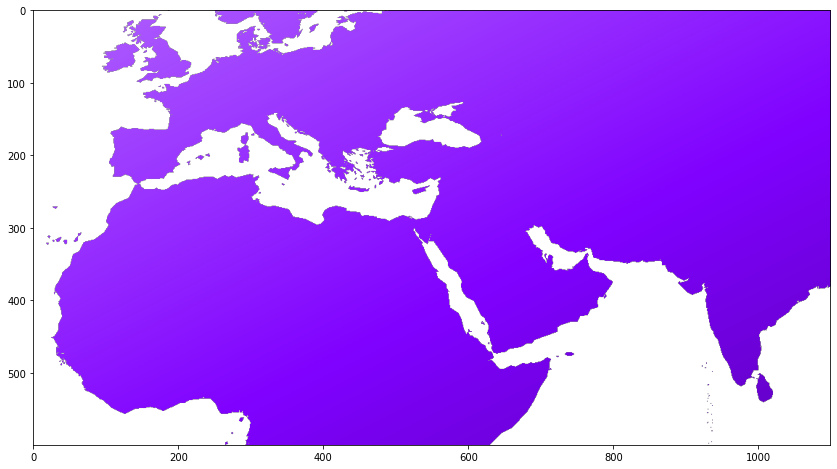

Waiting for updates...
Async response at 22:05:26
{
  "username": "dshum",
  "status": "running",
  "message": "The job is being processed",
  "progress": 40,
  "createdAt": "2020-07-10T02:05:15.540Z",
  "updatedAt": "2020-07-10T02:05:23.583Z",
  "links": [
    {
      "href": "https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/harmony/gdal/629c6a7f-4ec1-441a-9a3c-15acafd2b776/2020_01_01_7f00ff_global_subsetted.tif",
      "title": "G1234088196-EEDTEST",
      "type": "image/tiff",
      "rel": "data",
      "bbox": [
        -179.95,
        -89.95,
        179.95,
        89.95
      ],
      "temporal": {
        "start": "2020-01-01T00:00:00.000Z",
        "end": "2020-01-01T23:59:59.000Z"
      }
    },
    {
      "href": "https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/harmony/gdal/629c6a7f-4ec1-441a-9a3c-15acafd2b776/2020_01_02_3200ff_global_subsetted.tif",
      "title": "G1234088197-EEDTEST",
      "type": "imag

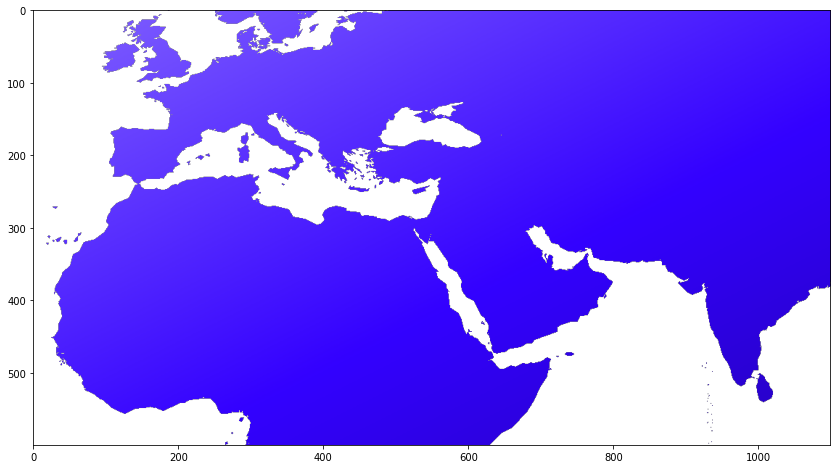

Waiting for updates...
Async response at 22:05:31
{
  "username": "dshum",
  "status": "running",
  "message": "The job is being processed",
  "progress": 80,
  "createdAt": "2020-07-10T02:05:15.540Z",
  "updatedAt": "2020-07-10T02:05:31.314Z",
  "links": [
    {
      "href": "https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/harmony/gdal/629c6a7f-4ec1-441a-9a3c-15acafd2b776/2020_01_01_7f00ff_global_subsetted.tif",
      "title": "G1234088196-EEDTEST",
      "type": "image/tiff",
      "rel": "data",
      "bbox": [
        -179.95,
        -89.95,
        179.95,
        89.95
      ],
      "temporal": {
        "start": "2020-01-01T00:00:00.000Z",
        "end": "2020-01-01T23:59:59.000Z"
      }
    },
    {
      "href": "https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/harmony/gdal/629c6a7f-4ec1-441a-9a3c-15acafd2b776/2020_01_02_3200ff_global_subsetted.tif",
      "title": "G1234088197-EEDTEST",
      "type": "imag

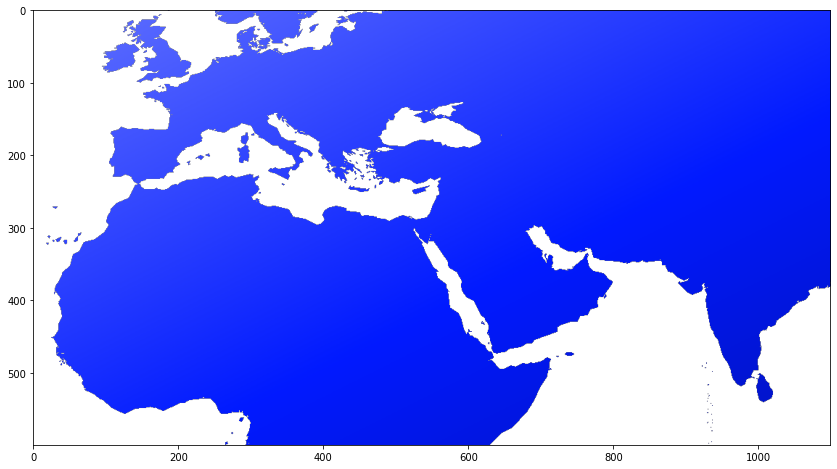

GET /service-results/harmony-uat-staging/public/harmony/gdal/629c6a7f-4ec1-441a-9a3c-15acafd2b776/2020_01_04_0065ff_global_subsetted.tif


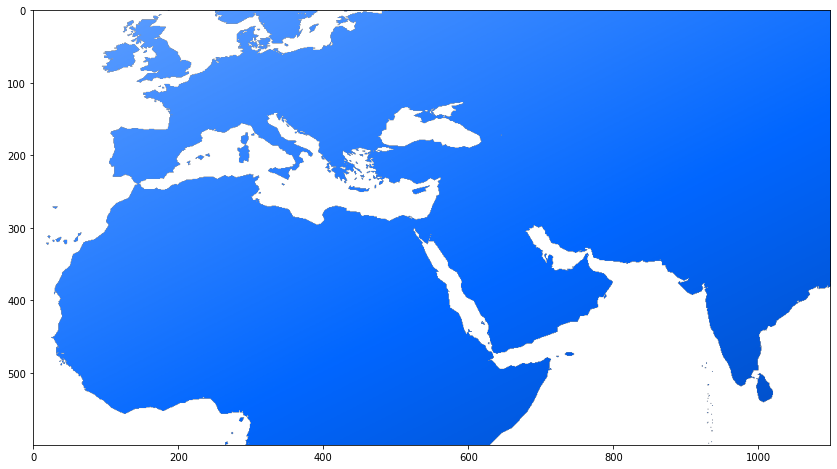

Waiting for updates...
Async response at 22:05:38
{
  "username": "dshum",
  "status": "successful",
  "message": "The job has completed successfully",
  "progress": 100,
  "createdAt": "2020-07-10T02:05:15.540Z",
  "updatedAt": "2020-07-10T02:05:36.163Z",
  "links": [
    {
      "title": "STAC catalog",
      "href": "https://harmony.uat.earthdata.nasa.gov/stac/8b0f7262-06c1-4d6d-8970-c19d45849e42/",
      "rel": "stac-catalog-json",
      "type": "application/json"
    },
    {
      "href": "https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/harmony/gdal/629c6a7f-4ec1-441a-9a3c-15acafd2b776/2020_01_01_7f00ff_global_subsetted.tif",
      "title": "G1234088196-EEDTEST",
      "type": "image/tiff",
      "rel": "data",
      "bbox": [
        -179.95,
        -89.95,
        179.95,
        89.95
      ],
      "temporal": {
        "start": "2020-01-01T00:00:00.000Z",
        "end": "2020-01-01T23:59:59.000Z"
      }
    },
    {
      "href": "https://

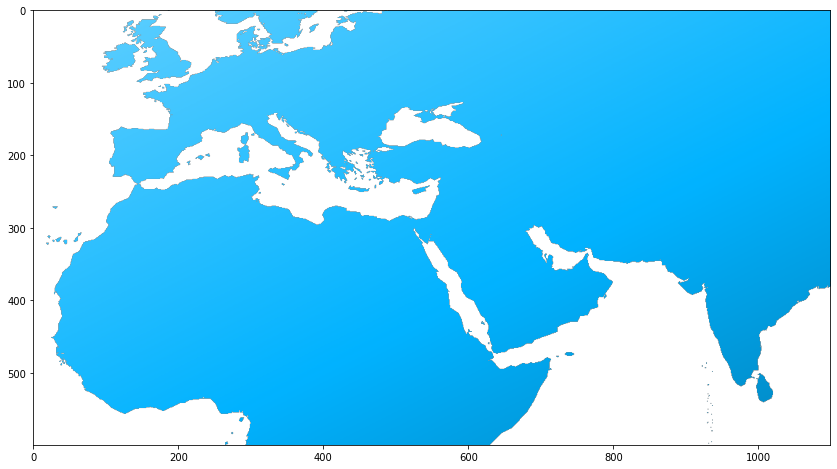

Async request is complete


<Response [200]>

In [5]:
response = get(
    coverages_root.format(
        collection=l3_collection, 
        variable='all'), 
    params={
        'subset': [
            'lon(-20:90)', 
            'lat(0:60)', 
            'time("2020-01-01T00:00:00Z":"2020-01-05T01:00:00Z")']})
show_async(response)

### Zarr Reformatting

In [ ]:
response = get(
    coverages_root.format(
        collection=l3_collection, 
        variable='all'), 
    params={'subset': 'time("2020-01-15T00:00:00Z":"2020-01-16T01:00:00Z")'},
    headers = {'accept': 'application/x-zarr'})

zarr_response = show_async(response)

In [ ]:
!{sys.executable} -m pip install -q 's3fs>=0.4.2' 'zarr>=2.4.0'

import s3fs
import zarr

urls = get_data_urls(zarr_response)
fs = s3fs.S3FileSystem(profile='uat')
store = fs.get_mapper(root=urls[0], check=False)
zarr_file = zarr.open(store)

print(zarr_file.tree())

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

image = np.dstack([np.flip(zarr_file[v][0,900:1500,1600:2700], 0) for v in ['red_var', 'green_var', 'blue_var', 'alpha_var']])
plt.imshow(image);

### STAC

In [ ]:
!{sys.executable} -m pip install -q 'sat-stac>=0.3.3'

from satstac import Catalog

stac_urls = [link['href'] for link in zarr_response.json()['links'] if link.get('rel', 'data') == 'stac-catalog-json']
cat = Catalog.open(stac_urls[0])

for i in cat.items():
    print('STAC Item')
    print('\t', 'ID:', i.id)
    print('\t', 'Date:', i.datetime)
    print('\t', 'Bounding Box:', i.bbox)
    print('\t', 'File:', list(i.assets.keys()))


### Cancel Job

In [12]:
#Add 3 requests
response1 = get(coverages_root.format(collection=l3_collection, variable='all'), params={'format': 'image/tiff'})
response2 = get(coverages_root.format(collection=l3_collection, variable='all'), params={'format': 'image/tiff'})
response3 = get(coverages_root.format(collection=l3_collection, variable='all'), params={'format': 'image/tiff'})

#List the requests
my_jobs = 'https://harmony.uat.earthdata.nasa.gov/jobs'
response = get(my_jobs,params={'page': '1','limit': '10'})
body = response.json()

for job in body['jobs']:
    print_async_status(job)

#Cancel one
my_jobs_cancel_root=my_jobs+'/{job_id}/cancel'
response = post(my_jobs_cancel_root.format(job_id=response3.json()['jobID']))

print_async_status(response.json())

assert response.json()['status'] == 'canceled'


GET /C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=image%2Ftiff
GET /jobs?page=1&limit=10
JobID: 8eb042cf-fc47-4862-8bf6-27284beef727 Status: running ( 0 %) Messages: CMR query identified 176 granules, but the request has been limited to process only the first 20 granules.
JobID: 3e9120f3-4e21-4dd8-a9c9-acb2b889d260 Status: canceled ( 0 %) Messages: Canceled by user.
JobID: c6e3eed7-f33f-4465-b219-564c2d9c63c1 Status: canceled ( 0 %) Messages: Canceled by user.
JobID: 2b9a612b-2254-4707-bf0c-d84f2e341110 Status: canceled ( 0 %) Messages: Canceled by user.
JobID: 7e88005f-bb3b-4a15-962c-46651411b01d Status: successful ( 100 %) Messages: CMR query identified 176 granules, but the request has been limited to process only the first 20 granules.
JobID: 91be2f13-88f9-4569-b006-1811808b6255 Status: successful ( 100 %) Messages: CMR query identified 176 granules, but the request has been limited to process only the first 20 granules.
JobID: d740331f-8838-

AssertionError: 

### Integration with Various Backend Services
Showing both sync and async requests to the PODAAC Subsetter, SWOT Reprojection Tool and Variable Subsetter

In [ ]:
#Sync Request (limited to 1 specific granule)
response = get(
    coverages_root.format(
        collection='C1234208437-POCLOUD', 
        variable='all'), 
    params={
        'granuleid':'G1234413304-POCLOUD',
        'subset': [
            'lon(-160:160)', 
            'lat(-80:80)'
            ]})
show(response)

In [ ]:
#Async Request
response = get(
    coverages_root.format(
        collection='C1234208437-POCLOUD', 
        variable='all'), 
    params={
        'subset': [
            'lon(-160:160)', 
            'lat(-80:80)',
             'time("2012-03-03T00:00:00Z":"2012-03-03T11:59:59Z")'
            ]})
show_async_condensed(response)

In [ ]:
#SWOT Repro Sync Request (limited to 1 specific granule)

response = get(
    coverages_root.format(
        collection=l2_collection, 
        variable='all'), 
    params={
        'granuleId':'G1233860486-EEDTEST',
        'outputCrs': '+proj=lcc +lat_1=43 +lat_2=62 +lat_0=30 +lon_0=10 +x_0=0 +y_0=0 +ellps=intl +units=m +no_defs',
        'interpolation': 'near',
        'scaleExtent': '-7000000,-1000000,8000000,8000000'})

show(response)

In [ ]:
#SWOT Repro Async Request

response = get(
    coverages_root.format(
        collection=l2_collection, 
        variable='all'), 
    params={
        'outputCrs': '+proj=lcc +lat_1=43 +lat_2=62 +lat_0=30 +lon_0=10 +x_0=0 +y_0=0 +ellps=intl +units=m +no_defs',
        'interpolation': 'near',
        'scaleExtent': '-7000000,-1000000,8000000,8000000'})

show_async_condensed(response)


_Minimizing time to science_